### Урок 5. Статистика в работе аналитика с библиотекой Scipy

Выполните задание:
Можно решить 2 задачи на выбор:
1. Взять датасет из домашнего задания №2. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.
2. Цех может производить стулья и столы. На производство стула идет 5 единиц материала, на производство стола - 20 единиц (футов красного дерева). Стул требует 10 человеко-часов, стол - 15. Имеется 400 единиц материала и 450 человеко-часов. Прибыль при производстве стула - 45 долларов США, при производстве стола - 80 долларов США. Сколько надо сделать стульев и столов, чтобы получить максимальную прибыль?
3. Средний накопленный доход на пользователя с сайта (cumulative ARPU) составил: day1 0.4$, day3 0.6$, day7 0.8$, day14 1.10$ , day21 1.30$, day30 1.40$. Подберите аппроксимирующую кривую и сделайте прогноз, сколько в среднем принесет денег пользователь на 90й день. Обоснуйте выбор одной из аппроксимирующей кривой вида: y = a*b^x или y = a*ln(x) + b.

### Задача 1

Взять датасет из домашнего задания №2. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [1]:
import pandas as pd
import numpy as np

df_mc = pd.read_csv('marketing_campaign.csv')
df_users = pd.read_csv('users.csv')
df_subscribers = pd.read_csv('subscribers.csv')
df = df_mc.merge(df_users, on = 'user_id').merge(df_subscribers, on = 'user_id')
df

,user_id,date_served,marketing_channel,variant,language_displayed,converted,age_group,language_preferred,subscribing_channel,date_subscribed,date_canceled,is_retained
0,a1000,1/1/18,House Ads,personalization,English,True,0-18 years,English,House Ads,1/1/18,NaN,True
1,a1001,1/1/18,House Ads,personalization,English,True,19-24 years,English,House Ads,1/1/18,NaN,True
2,a1002,1/1/18,House Ads,personalization,English,True,24-30 years,English,House Ads,1/1/18,NaN,True
3,a1003,1/1/18,House Ads,personalization,English,True,30-36 years,English,House Ads,1/1/18,NaN,True
4,a1004,1/1/18,House Ads,personalization,English,True,36-45 years,English,House Ads,1/1/18,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True,45-55 years,German,Email,1/17/18,1/24/18,False
10033,a11033,1/17/18,Email,control,German,True,55+ years,German,Email,1/17/18,NaN,True
10034,a11034,1/5/18,Instagram,control,German,False,55+ years,German,Email,1/17/18,NaN,True
10035,a11035,1/17/18,Email,control,German,True,0-18 years,German,Email,1/17/18,NaN,True


In [2]:
df1_1 = df.filter(items = ['converted','variant']).value_counts().unstack('converted').reset_index().set_index('variant')
df1_1['conversion']= df1_1[True] / (df1_1[False]+df1_1[True])
df1_1

converted,False,True,conversion
variant,,,
control,4705,371,0.073089
personalization,4241,705,0.142539


In [3]:
import scipy.stats as stats
df1_1.drop(['conversion'], axis=1, inplace=True)
result = stats.chi2_contingency(df1_1, correction = False)
chisq, pvalue = result[:2]
print('chisq = {}, pvalue = {}'.format(chisq, pvalue))

chisq = 126.07767827548582, pvalue = 2.9568009705199523e-29


Вывод: поскольку значимость A/B теста 3*10^-29 менее допустимого уровня значимости 0,05, то нулевую гипотезу о равенстве конверсий в группах можно отклонить, т.е. группа B -действительно генерирует статистически больше конверсий, чем группа A

In [4]:
df1_2 = df.filter(items = ['date_served','converted','variant']).value_counts().unstack('converted').reset_index()
df1_2['conversion']= df1_2[True] / (df1_2[False]+df1_2[True])
df1_2.rename(columns={False: "False", True: "True"})
df1_2

converted,date_served,variant,False,True,conversion
0,1/1/18,control,158,3,0.018634
1,1/1/18,personalization,179,35,0.163551
2,1/10/18,control,138,24,0.148148
3,1/10/18,personalization,162,18,0.100000
4,1/11/18,control,139,6,0.041379
...,...,...,...,...,...
57,1/7/18,personalization,117,17,0.126866
58,1/8/18,control,145,21,0.126506
59,1/8/18,personalization,135,18,0.117647
60,1/9/18,control,138,24,0.148148


In [6]:
df1_2.reset_index(drop=True)
df1_2['conversion_A'] = df1_2[df1_2['variant']=='control']['conversion']
df1_2['conversion_B'] = df1_2[df1_2['variant']=='personalization']['conversion']
df1_3 = df1_2.filter(items = ['date_served','conversion_A','conversion_B']).groupby('date_served').sum().reset_index()
df1_3

converted,date_served,conversion_A,conversion_B
0,1/1/18,0.018634,0.163551
1,1/10/18,0.148148,0.100000
2,1/11/18,0.041379,0.130178
3,1/12/18,0.042857,0.120482
4,1/13/18,0.035971,0.136095
5,1/14/18,0.035714,0.136095
6,1/15/18,0.087324,0.138249
7,1/16/18,0.161491,0.326087
8,1/17/18,0.240642,0.203209
9,1/18/18,0.046980,0.140351


In [7]:
t_stat, p_val= stats.ttest_ind(df1_3['conversion_A'],df1_3['conversion_B'])
t_stat , p_val

(-4.435404667114521, 3.9878081824156405e-05)

Вывод: поскольку значимость A/B теста 0.00003 менее допустимого уровня значимости 0.05, то нулевую гипотезу о равенстве конверсий в группах нужно отклонить, т.е. группа B генерирует статистически больше конверсий, чем группа A

In [10]:
df1_4 = df.filter(items = ['marketing_channel','converted','variant']).value_counts().unstack('converted').reset_index()
df1_4['conversion']= df1_4[True] / (df1_4[False]+df1_4[True])
df1_4.reset_index(drop=True)
df1_4['conversion_A'] = df1_4[df1_4['variant']=='control']['conversion']
df1_4['conversion_B'] = df1_4[df1_4['variant']=='personalization']['conversion']
df1_5 = df1_4.filter(items = ['marketing_channel','conversion_A','conversion_B']).groupby('marketing_channel').sum().reset_index()
df1_5

converted,marketing_channel,conversion_A,conversion_B
0,Email,0.291971,0.388316
1,Facebook,0.058166,0.191511
2,House Ads,0.067398,0.057772
3,Instagram,0.058559,0.216684
4,Push,0.032051,0.129524


In [11]:
t_stat, p_val= stats.ttest_ind(df1_5['conversion_A'],df1_5['conversion_B'])
t_stat , p_val

(-1.300966777562293, 0.22948817960504983)

Также необходимо отметить, что гипотеза о росте конверсий справедлива не по всем каналам привлечения клиентов

### Задача 2

Цех может производить стулья и столы. На производство стула идет 5 единиц материала, на производство стола - 20 единиц (футов красного дерева). Стул требует 10 человеко-часов, стол - 15. Имеется 400 единиц материала и 450 человеко-часов. Прибыль при производстве стула - 45 долларов США, при производстве стола - 80 долларов США. Сколько надо сделать стульев и столов, чтобы получить максимальную прибыль?

In [14]:
# Задаем целевую функцию:
# Компанией производится 2 вида продукции:
# x0 — стулья - $45
# x1 — столы - $80

def value2_1(x):
    return 0.0 - 45*x[0] - 80*x[1]

# Задаем систему ограничений:
# по материалам и по трудозатратам

neq_cons = {'type': 'ineq',
             'fun': lambda x: np.array ([400 - 5 * x [0] - 20 * x [1],
                                         450 - 10  * x [0] - 15 * x [1]])}

# Формальное ограничение — выпуск продукции должен быть только положительным:
from scipy.optimize import Bounds
bnds = Bounds([0, 0], [np.inf, np.inf])

# Максимизируем функцию ежемесячной прибыли
from scipy.optimize import minimize
x0 = np.array([10.0, 10.0])
res = minimize(value2_1, x0, method='SLSQP', constraints=neq_cons, bounds=bnds)
print(res.x)

[24. 14.]


In [15]:
# x = (24, 14) :
print('затраты материалов:', 5*24 + 20*14, 'футов из', 400)
print('трудозатраты:', 10*24 + 15*14, 'чел.*час из', 450)
print('максимизированная прибыль составит: $', -1*value2_1([24, 14]))

затраты материалов: 400 футов из 400
трудозатраты: 450 чел.*час из 450
максимизированная прибыль составит: $ 2200.0


Вывод производство 24 стульев и 14 столов обеспечит максимальную прибыль $2200 и приведет к расходованию всех доступных ресурсов.

### Задача 3

Средний накопленный доход на пользователя с сайта (cumulative ARPU) составил: day1 0.4,𝑑𝑎𝑦30.6, day7 0.8,𝑑𝑎𝑦141.10 , day21 1.30,𝑑𝑎𝑦301.40. Подберите аппроксимирующую кривую и сделайте прогноз, сколько в среднем принесет денег пользователь на 90й день. Обоснуйте выбор одной из аппроксимирующей кривой вида: y = ab^x или y = aln(x) + b.

In [17]:
df3 = pd.DataFrame({'day': [1,3,7,14,21,30],
                   'cumARPU': [0.4,0.6,0.8,1.10,1.30,1.40]})
df3.head(6)

,day,cumARPU
0,1,0.4
1,3,0.6
2,7,0.8
3,14,1.1
4,21,1.3
5,30,1.4


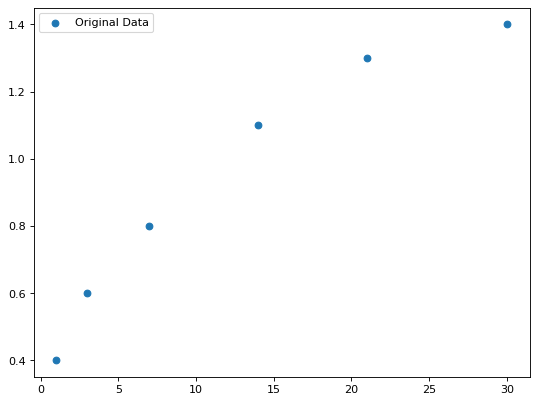

In [55]:
# определяем тип возможной кривой по диаграмме рассеяния
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df3['day'], df3['cumARPU'], label="Original Data" )
plt.legend()
plt.show()

log_err =array([ 1.27704535e-01,  4.14092189e+06, -1.26977440e+06]), 
exp_err =array([-0.04054433,  0.1198521 ,  0.03722537])


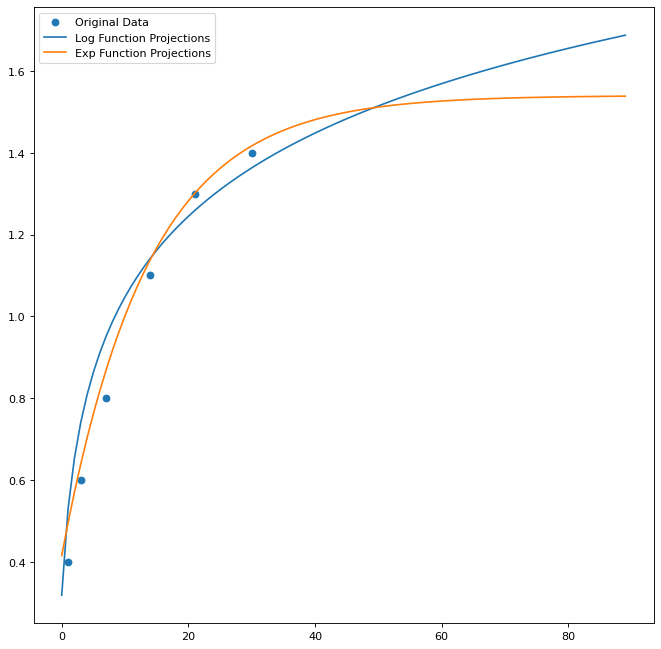

In [61]:
# задаем аппроксимирующую логарифмическую функцию
def log_func( x, a, b, c ):
    return a * np.log( b*x ) + c

# задаем аппроксимирующую экспоненциальную функцию 
# (в задании наверно опечатка - какой смысл вводить 2 параметра, чтобы их перемножать)
def exp_func( x, a, b, c ):
    return a * np.exp( -b * x ) + c

# подбираем оптимальные параметры функций
from scipy.optimize import curve_fit
log_popt, log_pcov = curve_fit(log_func, df3['day'], df3['cumARPU'])
exp_popt, exp_pcov = curve_fit(exp_func, df3['day'], df3['cumARPU'])
log_err = np.sqrt(np.diag(log_pcov))/log_popt
exp_err = np.sqrt(np.diag(exp_pcov))/exp_popt
print(f'{log_err =}, \n{exp_err =}')

# задаем точку прогноза - сколько в среднем принесет денег пользователь на 90й день
projection_endpoint = 90

# задаем значения функции x с помощью метода np.arange и параметры подобранной кривой
log_y_projected = log_func( np.arange( 1, projection_endpoint + 1 ), *log_popt )
exp_y_projected = exp_func( np.arange( 1, projection_endpoint + 1 ), *exp_popt )

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df3['day'], df3['cumARPU'], label="Original Data" )
plt.plot( log_y_projected, label="Log Function Projections" )
plt.plot( exp_y_projected, label="Exp Function Projections" )
plt.legend()
plt.show()

In [50]:
print(f'{log_y_projected[89] =}, {exp_y_projected[89] =}')

log_y_projected[89] =1.687325756038148, exp_y_projected[89] =1.5383171691245061


По графику а также по стандартному отклонению параметров видно, что экспоненциальная функция дает более точный прогноз - 1.54.
Подобное поведение логично, если падение ARPU в день пропорционально APRU (линейное падение дневной выручки).

In [56]:
# Кмк, в данном случае речь о падении APRU в день со временем, как правило, падение идет от текущего значения
df3_2 = pd.DataFrame({'day': [1,3,7,14,21,30],
                      'cumARPU': [0.4,0.6,0.8,1.10,1.30,1.40]})
df3_2['avg cumARPU'] = df3_2['cumARPU']/df3_2['day']
df3_2.head(6)

,day,cumARPU,avg cumARPU
0,1,0.4,0.400000
1,3,0.6,0.200000
2,7,0.8,0.114286
3,14,1.1,0.078571
4,21,1.3,0.061905
5,30,1.4,0.046667


In [58]:
df3_3 = pd.DataFrame({'day': [1,(3+1)/2,(7+3)/2,(14+7)/2,(14+21)/2,(21+30)/2],
                      'ARPU': [0.4, (0.6 - 0.4)/2,(0.8-0.6)/4,(1.10-0.8)/7,(1.30-1.10)/7,(1.40-1.30)/9]})
df3_3.head(6)

,day,ARPU
0,1.0,0.400000
1,2.0,0.100000
2,5.0,0.050000
3,10.5,0.042857
4,17.5,0.028571
5,25.5,0.011111


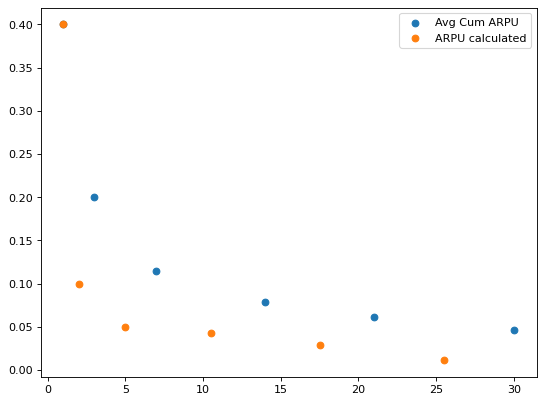

In [60]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df3_2['day'], df3_2['avg cumARPU'], label="Avg Cum ARPU" )
plt.scatter(df3_3['day'], df3_3['ARPU'], label="ARPU calculated" )
plt.legend()
plt.show()

my_err =array([0.13132477, 0.        , 0.        ])


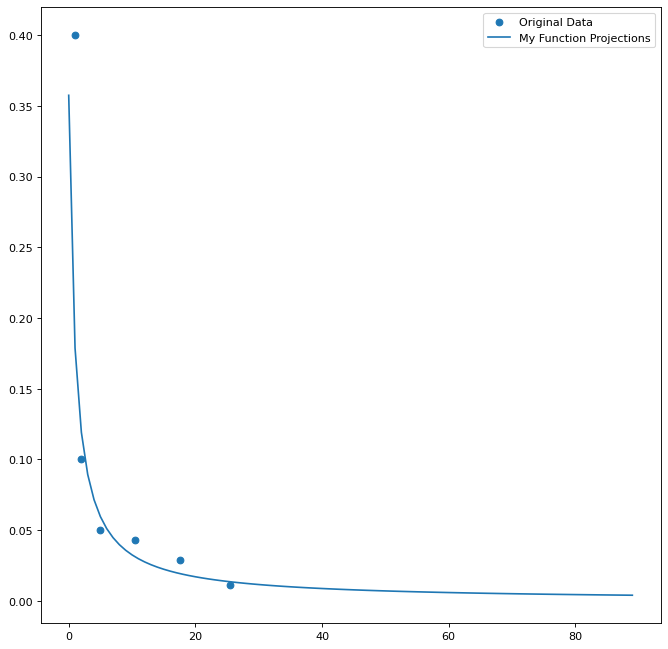

In [76]:
def my_func_in_day( x, a, b, c):
    return a / x

my_popt, my_pcov = curve_fit(my_func_in_day, df3_3['day'], df3_3['ARPU'], method='trf')
my_err = np.sqrt(np.diag(my_pcov))/my_popt
print(f'{my_err =}')

my_y_projected_in_day = my_func_in_day( np.arange( 1, projection_endpoint + 1 ), *my_popt )
my_y_projected = np.cumsum(my_y_projected_in_day)

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df3_3['day'], df3_3['ARPU'], label="Original Data" )
plt.plot( my_y_projected_in_day, label="My Function Projections" )
plt.legend()
plt.show()

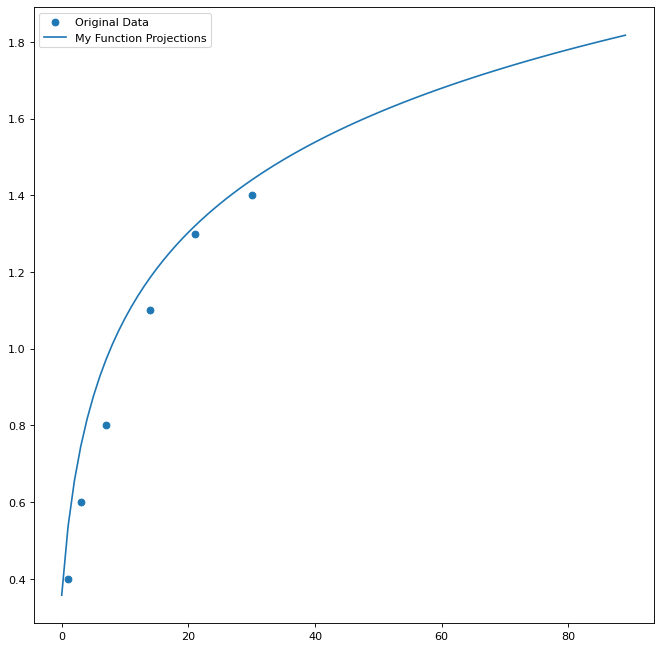

In [77]:
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df3_2['day'], df3_2['cumARPU'], label="Original Data" )
plt.plot( my_y_projected, label="My Function Projections" )
plt.legend()
plt.show()

In [78]:
print(f'{my_y_projected[89] =}')

my_y_projected[89] =1.8170773057022525


Функция curve_fit работает плохо, вероятно, надо лучше в ней разобраться. По такому числу точек экспонента без проблем должна подбираться.
Не понятно, как вообще может нормально работать функция без привязки к типу зависимости. Параметр-слагаемое и показатель степени для нее равноценны что ли? Т.е. алгоритм очень не устойчивый по параметрам, получается.